### **Import and Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np                                              
import pandas as pd                                             
import matplotlib.pyplot as plt                                 
import torchvision                
import torchvision.transforms as transforms              
from torch.utils.data import SubsetRandomSampler 
import torch.utils.data as data   
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import sys
from time import time
sys.path.append('/content/drive/My Drive/ECE324 project/Additional files')
sys.path.append('/content/drive/My Drive/ECE324 project/Clean Data')
from Data_Loader import *


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


###**Next is the actual instantiation of Dataloader classes, but for this need batch_size argument for the train Dataloader class**


In [ ]:

my_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224)),
  transforms.Normalize(mean = [0.66445047,0.55465436,0.447036], std = [0.321551,0.33547384,0.3524585])
  ])

dataset =  torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/ECE324 project/Clean Data', transform=my_transform)

train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [9600,2400,2999], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_data, batch_size=64,shuffle= True)                  
valid_loader = DataLoader(valid_data, batch_size=64,shuffle= True)
test_loader = DataLoader(test_data, batch_size=64,shuffle= True)

def relabel_state(argument):
    switcher = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
        9: 1,
        10:2,
        11:2,
        12:2,
        13:2,
        14:2}
    return switcher[argument.item()]

def relabel_type(argument):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 0,
        6: 1,
        7: 2,
        8: 3,
        9: 4,
        10:0,
        11:1,
        12:2,
        13:3,
        14:4}
    return switcher[argument.item()]

### **Various CNN architectures- Still not done**


In [57]:
# CNN Model
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    # Convolution layers
    self.conv1 = nn.Conv2d(3,6,5) # 6 kernels, 5x5
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5) # 16 kernels, 5x5

    # MLP State
    self.fc1 = nn.Linear(44944,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,3)

    # MLP Type
    self.fc4 = nn.Linear(44944,120)
    self.fc5 = nn.Linear(120,84)
    self.fc6 = nn.Linear(84,5)

    #self.drop = nn.Dropout(p=0.5)
    #self.drop_conv = nn.Dropout(p=0.1)
    self.Bn1 = nn.BatchNorm2d(6)
    self.Bn2 = nn.BatchNorm2d(16)
    #self.batchnorm = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  def forward(self,x):
    x = self.pool(F.relu(self.Bn1(self.conv1(x))))
    x = self.pool(F.relu(self.Bn2(self.conv2(x))))
    x = x.view(x.size(0), -1)

    # State head
    x1 = F.relu(self.fc1(x))
    x1 = F.relu(self.fc2(x1))
    x1 = self.fc3(x1)

    # Type head
    x2 = F.relu(self.fc4(x))
    x2 = F.relu(self.fc5(x2))
    x2 = self.fc6(x2)

    return x1, x2

In [ ]:
class CNN_(nn.Module):
  def __init__(self):
    super(CNN_,self).__init__()
    # Convolution layers
    self.conv1 = nn.Conv2d(3,6,5) # 6 kernels, 5x5
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,8,5) # 16 kernels, 5x5
    self.conv3 = nn.Conv2d(8,12,5)

    # MLP State
    self.fc1 = nn.Linear(6912,100)
    self.fc2 = nn.Linear(100,54)
    self.fc3 = nn.Linear(54,3)

    # MLP Type
    self.fc4 = nn.Linear(6912,100)
    self.fc5 = nn.Linear(100,54)
    self.fc6 = nn.Linear(54,5)

    self.drop = nn.Dropout(p=0.5)
    

    #self.batchnorm = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)


    # State head
    x1 = F.relu(self.fc1(x))
    x1 = F.relu(self.fc2(x1))
    x1 = self.fc3(x1)

    # Type head
    x2 = F.relu(self.fc4(x))
    x2 = F.relu(self.fc5(x2))
    x2 = self.fc6(x2)

    return x1, x2

### **Training loop - Instantiate arguments and parameters**

In [58]:
#MODEL ARGUMENTS
lr = 0.01
epochs = 20
eval_every = 5
model = CNN()

model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fnc= torch.nn.CrossEntropyLoss()

loss_fnc.to(device)



#OUTPUT DATA ARGUMENTS
seed = 1
torch.manual_seed(seed)
save= True
confusion=True
plot = True
statistics = True

### **Training loop using train and validation**

In [ ]:
#Prepare plotting lists
train_loss_list = []
valid_loss_list = []
test_loss_list = []
train_acc_list = []
valid_acc_list = []
test_acc_list = []

train_loss_list_state = []
valid_loss_list_state = []
test_loss_list_state = []
train_acc_list_state = []
valid_acc_list_state = []
test_acc_list_state = []

train_loss_list_type = []
valid_loss_list_type = []
test_loss_list_type = []
train_acc_list_type = []
valid_acc_list_type = []
test_acc_list_type = []


epoch_list = []         #Epoch number
start = time()          #Time training process

for e in range(epochs):
    running_loss = []
    running_accuracy = []
    running_loss_state = []
    running_accuracy_state = []
    running_loss_type = []
    running_accuracy_type = []


    running_valid_loss = []
    running_valid_accuracy = []
    running_valid_loss_state = []
    running_valid_accuracy_state = []
    running_valid_loss_type = []
    running_valid_accuracy_type = []

    '''running_test_loss = []
    running_test_accuracy = []
    running_test_loss_state = []
    running_test_accuracy_state = []
    running_test_loss_type = []
    running_test_accuracy_type = []'''

    print("going thru data , epoch {}".format(e))
  #               LOOKING AT TRAINING DATA

    for i, data in enumerate(train_loader):

               #get batch of 

        
        #inputs, label = data

        #label_state = torch.zeros(len(label))
        #label_type = torch.zeros(len(label))

        inputs, label = data[0].to(device),data[1].to(device)

        label_state = torch.zeros(len(label)).to(device)
        label_type = torch.zeros(len(label)).to(device)

        for k in range(len(label)):
          label_state[k] = relabel_state(label[k])
          label_type[k] = relabel_type(label[k])





            #setting gradients to zero and running model on batch
        optimizer.zero_grad()
        predictions_state, predictions_type = model(inputs)

            #computing loss based on Cross Entropy
        batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
        batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

        #Combining losses and calculating gradients
        Overall_loss = batch_loss_state + batch_loss_type
        Overall_loss.backward()
        optimizer.step()
        #evaluating Training Acc
        _, predicted_state = torch.max(predictions_state.data, 1)
        _,predicted_type = torch.max(predictions_type.data, 1)
        trainAcc_state = (label_state == predicted_state).sum().item() / 64
        trainAcc_type = (label_type == predicted_type).sum().item() /64

        if i % eval_every == 0:
            print("epoch: {} |||   loss type:   {}  trainAcc type:   {} |||  loss state {}  trainAcc state:  {}  ".format(e+1, batch_loss_type, trainAcc_type, batch_loss_state, trainAcc_state))

        running_loss.append(Overall_loss.item())
        running_accuracy.append((trainAcc_state+trainAcc_type)/2)
        running_loss_state.append(batch_loss_state.item())
        running_accuracy_state.append(trainAcc_state)
        running_loss_type.append(batch_loss_type.item())
        running_accuracy_type.append(trainAcc_type)
        del Overall_loss
        del batch_loss_state
        del batch_loss_type
        del label_state
        del label_type
        del predictions_state
        del predictions_type

        
    #               LOOKING AT Validation DATA
    for j, data_v in enumerate(valid_loader):
            #get batch of data
        inputs_v, label_v = data_v[0].to(device),data_v[1].to(device)
    
        label_state_v = torch.zeros(len(label_v)).to(device)
        label_type_v = torch.zeros(len(label_v)).to(device)

        #inputs_v, label_v = data_v
    
        #label_state_v = torch.zeros(len(label_v))
        #label_type_v = torch.zeros(len(label_v))
        for a in range(len(label_v)):
          label_state_v[a] = relabel_state(label_v[a])
          label_type_v[a] = relabel_type(label_v[a])

          #run model on validation batch
        predictions_state_v, predictions_type_v = model(inputs_v)

            #compute loss
        batch_valid_loss_state = loss_fnc(input=predictions_state_v.squeeze(), target=label_state_v.long())
        batch_valid_loss_type = loss_fnc(input=predictions_type_v.squeeze(), target=label_type_v.long())

        Overall_loss_v = batch_valid_loss_state + batch_valid_loss_type

            #evaluate
        _, predicted_state_v = torch.max(predictions_state_v.data, 1)
        _,predicted_type_v = torch.max(predictions_type_v.data, 1)

        validAcc_state = (label_state_v == predicted_state_v).sum().item() / 64
        validAcc_type = (label_type_v == predicted_type_v).sum().item() / 64

        if j % eval_every == 0:
             print("epoch: {} |||   vloss type:   {}  validAcc type:   {} |||  vloss state {}  validAcc state:  {}  ".format(e+1, batch_valid_loss_type, validAcc_type, batch_valid_loss_state,validAcc_state))
        
        running_valid_loss.append(Overall_loss_v.item())
        running_valid_accuracy.append((validAcc_state+validAcc_type)/2)
    
        running_valid_loss_state.append(batch_valid_loss_state.item())
        running_valid_accuracy_state.append(validAcc_state)
        running_valid_loss_type.append(batch_valid_loss_type.item())
        running_valid_accuracy_type.append(validAcc_type)

        del Overall_loss_v
        del batch_valid_loss_state
        del batch_valid_loss_type
        del label_state_v
        del label_type_v
        del predictions_state_v
        del predictions_type_v


    #               LOOKING AT test DATA
    '''for k, (data_state_test, data_type_test) in enumerate((zip(test_loader_state,test_loader_type)):
            #get batch of data
        inputs_state_t, labels_state_t = data_state_test
        inputs_type_t, labels_type_t = data_type_test
        if inputs_state_t!= inputs_type_t:
          print(" STOP THE TRAINING")
          print(" !!!!!!!!!  You screwed up the test dataloader (for {})    !!!!!!!!!!!!".format(i))
          print(" !!!!!!!!!  You screwed up the test dataloader (for {})    !!!!!!!!!!!!".format(i))
          print(" !!!!!!!!!  You screwed up the test dataloader (for {})    !!!!!!!!!!!!".format(i))
          print(" STOP THE TRAINING")
          break
        else:
          inputs_t = inputs_state_t    

          #run model on validation batch
        predictions_state_t, predictions_type_t = model(inputs_t)

            #compute loss
        batch_test_loss_state = loss_fnc(input=predictions_state_t.squeeze(), target=labels_state_t.long())
        batch_test_loss_type = loss_fnc(input=predictions_type_t.squeeze(), target=labels_type_t.long())

        Overall_loss_t = batch_test_loss_state + batch_test_loss_type

            #evaluate
        _, predicted_state_t = torch.max(predictions_state_t.data, 1)
        _,predicted_type_t = torch.max(predictions_type_t.data, 1)

        testAcc_state = (labels_state_t == predicted_state_t).sum().item() / len(test_idx)
        testAcc_type = (labels_type_t == predicted_type_t).sum().item() / len(test_idx)

        if k % eval_every == 0:
             print("epoch: {} |||   test loss type:   {}  testAcc type:   {} |||  test loss state {}  testAcc state:  {}  ".format(e+1, batch_test_loss_type, testAcc_type, batch_test_loss_state, testAcc_state))
        
        running_test_loss.append(Overall_loss_t)
        running_test_accuracy.append((testAcc_state+testAcc_type)/2)
    
        running_test_loss_state.append(batch_test_loss_state)
        running_test_accuracy_state.append(testAcc_state)
        running_test_loss_type.append(batch_test_loss_type)
        running_test_accuracy_type.append(testAcc_type)'''




        #--------------Storing data from every epoch into lists--------------

    #             lists for TRAINING accuracy
    #Overall accuracy
    trainacc_ = sum(running_accuracy) / float(len(running_accuracy))
    train_acc_list.append(trainacc_)
    #state accuracy
    trainacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))
    train_acc_list_state.append(trainacc_state_)
    #type accuracy
    trainAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))
    train_acc_list_type.append(trainAcc_type_)

    #             lists for TRAINING losses
    #Overall Loss
    loss_ = sum(running_loss) / float(len(running_loss))
    train_loss_list.append(loss_)
    #State Loss
    loss_state_ = sum(running_loss_state) / float(len(running_loss_state))
    train_loss_list_state.append(loss_state_)
    #Type Loss
    loss_type_ = sum(running_loss_type) / float(len(running_loss_type))
    train_loss_list_type.append(loss_type_)


    #------------------------------------------------------------------------------------
    #             lists for VALIDATION accuracy
    #Overall accuracy
    validacc_ = sum(running_valid_accuracy) / float(len(running_valid_accuracy))
    valid_acc_list.append(validacc_)
    #state accuracy
    validacc_state_ = sum(running_valid_accuracy_state) / float(len(running_valid_accuracy_state))
    valid_acc_list_state.append(validacc_state_)
    #type accuracy
    validAcc_type_ = sum(running_valid_accuracy_type) / float(len(running_valid_accuracy_type))
    valid_acc_list_type.append(validAcc_type_)

    #             lists for VALIDATION losses
    #Overall Loss
    valid_loss_ = sum(running_valid_loss) / float(len(running_valid_loss))
    valid_loss_list.append(valid_loss_)
    #State Loss
    valid_loss_state_ = sum(running_valid_loss_state) / float(len(running_valid_loss_state))
    valid_loss_list_state.append(valid_loss_state_)
    #Type Loss
    valid_loss_type_ = sum(running_valid_loss_type) / float(len(running_valid_loss_type))
    valid_loss_list_type.append(valid_loss_type_)

    #------------------------------------------------------------------------------------
        #             lists for TEST accuracy
    #Overall accuracy
    '''testacc_ = sum(running_test_accuracy) / float(len(running_test_accuracy))
    test_acc_list.append(testacc_)
    #state accuracy
    testAcc_state_ = sum(running_test_accuracy_state) / float(len(running_test_accuracy_state))
    test_acc_list_state.append(testAcc_state_)
    #type accuracy
    testAcc_type_ = sum(running_test_accuracy_type) / float(len(running_test_accuracy_type))
    test_acc_list_type.append(testAcc_type_)

    #             lists for TEST losses
    #Overall Loss
    test_loss_ = sum(running_test_loss) / float(len(running_test_loss))
    test_loss_list.append(test_loss_)
    #State Loss
    test_loss_state_ = sum(running_test_loss_state) / float(len(running_test_loss_state))
    test_loss_list_state.append(test_loss_state_)
    #Type Loss
    test_loss_type_ = sum(running_test_loss_type) / float(len(running_test_loss_type))
    test_loss_list_type.append(test_loss_type_)'''


    epoch_list.append(e)

end = time()

#Quick training stats
print("Total training time: ", end - start)
print("Epochs trained for:",len(epoch_list))
print("Max train Acc: ", max(train_acc_list))
print("Max valid Acc: ", max(valid_acc_list))
#print("Max test Acc: ", max(test_acc_list))


### **PLOTTING**

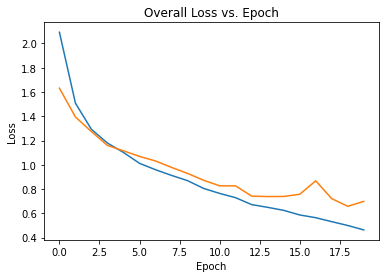

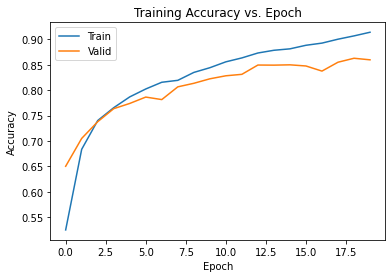

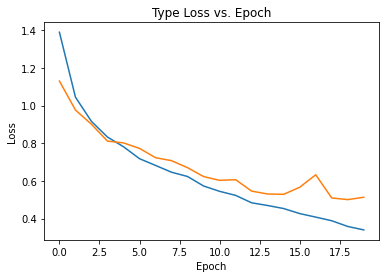

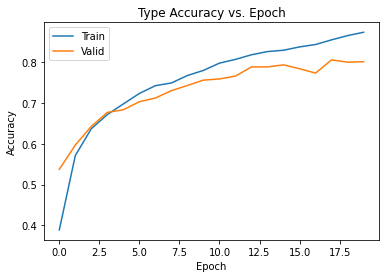

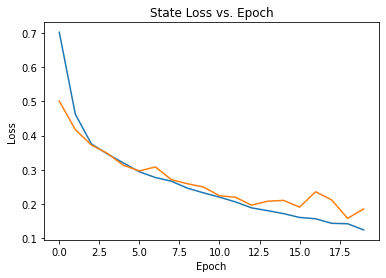

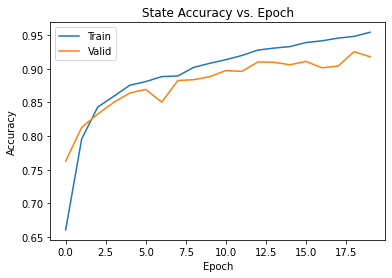

In [ ]:
if plot == True:
        #Plot overall loss vs epoch
        plt.plot(epoch_list, train_loss_list, label='Train')
        plt.plot(epoch_list, valid_loss_list, label='Valid')
        plt.title('Overall Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        #Plot overall Accuracy vs epoch
        plt.plot(epoch_list, train_acc_list, label='Train')
        plt.plot(epoch_list, valid_acc_list, label='Valid')
        plt.title('Training Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

                #Plot TYPE loss vs epoch
        plt.plot(epoch_list, train_loss_list_type, label='Train')
        plt.plot(epoch_list, valid_loss_list_type, label='Valid')
        plt.title('Type Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

                #Plot TYPE Accuracy vs epoch
        plt.plot(epoch_list, train_acc_list_type, label='Train')
        plt.plot(epoch_list, valid_acc_list_type, label='Valid')
        plt.title('Type Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

                #Plot STATE loss vs epoch
        plt.plot(epoch_list, train_loss_list_state, label='Train')
        plt.plot(epoch_list, valid_loss_list_state, label='Valid')
        plt.title('State Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

                #Plot STATE Accuracy vs epoch
        plt.plot(epoch_list, train_acc_list_state, label='Train')
        plt.plot(epoch_list, valid_acc_list_state, label='Valid')
        plt.title('State Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()



### **Confusion Matrix**


In [ ]:
#Calculating the confusion matrix
if confusion == True:
    transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    target_transform = transforms.Compose([transforms.Lambda(lambda x: one_hot(x, 10))])
    dataTest = torchvision.datasets.ImageFolder('/Users/arnauddeza/PycharmProjects/2020-SUMMER/Michael-Liut-Piazza-Bot/ECE324/ASS_4/training_v2', transform=transform,
                                                    target_transform=target_transform)
    _, Confuse_validData = train_test_split(dataTest, test_size=0.2, random_state=1)
    inputs = [0 for i in range(len(Confuse_validData))]
    for i in range(len(inputs)):
            inputs[i] = Confuse_validData[i][0].tolist()
    inputs = torch.FloatTensor(inputs)
    outputs = model(inputs)
    outputs = unencode(outputs)
    labels = [Confuse_validData[i][1].tolist() for i in range(len(Confuse_validData))]
    labels = unencode(torch.FloatTensor(labels))
    print(confusion_matrix(labels, outputs))
    #saving model if part 6

### **F1, RECALL, ETC (Performance Stats)**


### **Summary of model**


In [ ]:
if summary == True:
  summary(model, (3, 224, 224))


### **Saving model**


In [ ]:
if save == True:
    torch.save(model.state_dict(),'MyBest.pt')

# **SPECIALIZED TEST SETS**
### **Background check**